# **Loading Stock Data**

In [12]:
%pip install yfinance
%pip install scikit-learn
%pip install ta

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[*********************100%%**********************]  1 of 1 completed
f:\Projects\Stock Preditction\src\.venv\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
C:\Users\user\AppData\Local\Temp\ipykernel_4860\4107616084.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


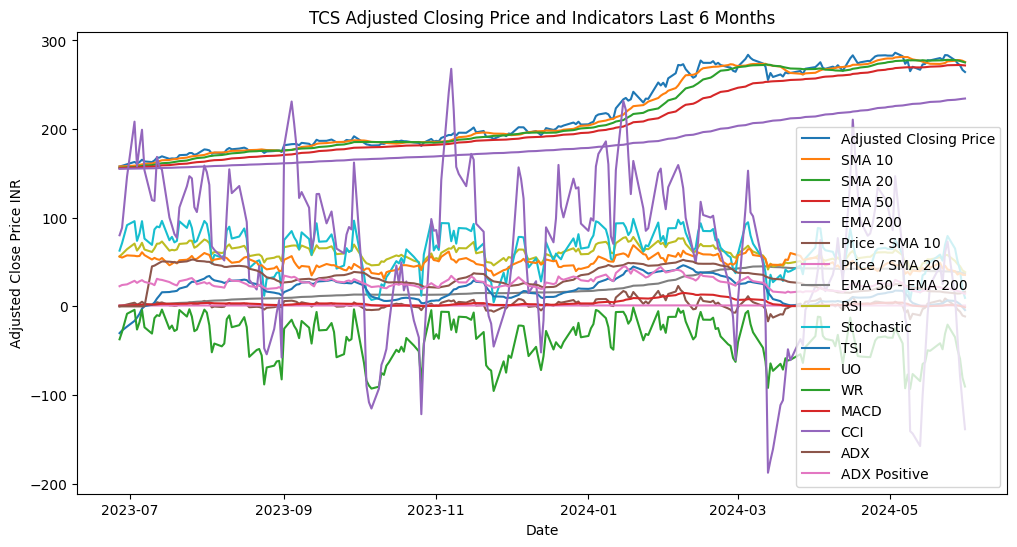

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta import add_all_ta_features
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Download TCS stock data for the last 6 months
ticker = ['TCS.NS', 'TATAMOTORS.NS', 'INFY.NS', 'ASIANPAINT.NS', 'ONGC.NS']
stock_idx = 4
data = yf.download(ticker[stock_idx], period='1y', interval='1d')



# Use the adjusted closing price

data = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# preprocess
data = data.fillna(method='ffill')

# Remove outliers
data = data[(data['Close'] - data['Close'].mean()).abs() < 3 * data['Close'].std()]

# Log transform
# data['Close'] = np.log(data['Close'])

# Scale the features
# scaler = MinMaxScaler()
# data[['Close', 'Volume']] = scaler.fit_transform(data[['Close', 'Volume']])


# data.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
# data = data[['Adj Close']]
# data.rename(columns={'Adj Close': 'Close'}, inplace=True)

# Calculate simple moving averages and exponential moving averages
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Create additional features
data['PRICE_SMA_10'] = data['Close'] - data['SMA_10']
data['PRICE_SMA_20_Ratio'] = data['Close'] / data['SMA_20']
data['EMA_DIFF'] = data['EMA_50'] - data['EMA_200']

data = data.dropna()

# Plot the adjusted closing price
# Plot the adjusted closing price and indicators
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Adjusted Closing Price')
plt.plot(data['SMA_10'], label='SMA 10')
plt.plot(data['SMA_20'], label='SMA 20')
plt.plot(data['EMA_50'], label='EMA 50')
plt.plot(data['EMA_200'], label='EMA 200')
plt.plot(data['PRICE_SMA_10'], label='Price - SMA 10')
plt.plot(data['PRICE_SMA_20_Ratio'], label='Price / SMA 20')
plt.plot(data['EMA_DIFF'], label='EMA 50 - EMA 200')
plt.plot(data['momentum_rsi'], label='RSI')
plt.plot(data['momentum_stoch'], label='Stochastic')
plt.plot(data['momentum_tsi'], label='TSI')
plt.plot(data['momentum_uo'], label='UO')
plt.plot(data['momentum_wr'], label='WR')
plt.plot(data['trend_macd'], label='MACD')
plt.plot(data['trend_cci'], label='CCI')
plt.plot(data['trend_adx'], label='ADX')
plt.plot(data['trend_adx_pos'], label='ADX Positive')

plt.title('TCS Adjusted Closing Price and Indicators Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price INR')
plt.legend()
plt.show()



In [3]:
# combine DataFrame

stock_list = ["TCS", "Tata_Motors", "Infosys", "Asian_Paints", "ONGC"]
sentiment_data = pd.read_csv(rf'../Dataset/{stock_list[stock_idx]}_sentiment_data.csv')
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])
sentiment_data.set_index('Date', inplace=True)

# Combine with the adjusted closing price data
combined_df = data.join(sentiment_data, how='left')

# Fill any missing sentiment scores (if necessary) - for example, with 0 for neutrality
combined_df.fillna({'Label': 0}, inplace=True)

print(combined_df.head())
# combined_df.to_csv('combined_data.csv')



                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-27  158.850006  158.850006  157.350006  157.850006  150.626831   
2023-06-28  157.850006  160.149994  156.550003  158.550003  151.294785   
2023-06-30  161.000000  161.000000  158.949997  160.300003  152.964706   
2023-07-03  160.300003  163.250000  160.000000  162.899994  155.445724   
2023-07-04  162.500000  162.899994  160.000000  161.199997  153.823517   

              Volume    volume_adi  volume_obv  volume_cmf     volume_fi  ...  \
Date                                                                      ...   
2023-06-27   9730174  2.211574e+07   111096460    0.082695 -5.195234e+04  ...   
2023-06-28  40243993  2.658741e+07   151340453    0.104728  3.979851e+06  ...   
2023-06-30   7840112  2.907333e+07   159180565    0.162660  5.371329e+06  ...   
2023-07-03   9548822  3.656544e+07   168729387    0.169026  8.150689e+06  ..

In [4]:
combined_df.shape

(227, 100)

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Select features and target variable
features = combined_df[['Close', 'Label','momentum_rsi', 'momentum_stoch', 'momentum_tsi', 'momentum_uo', 'momentum_wr', 'trend_macd', 'trend_cci', 'trend_adx', 'trend_adx_pos']]
target = combined_df['Close']

corr = combined_df.corr()["Close"].abs().sort_values(ascending=False)

# Select the top N features based on correlation
N = 19 # Number of features to select
top_n_features = corr.head(N).index.tolist()
top_n_features.insert(1, 'Label')
print(top_n_features)

# Create a new DataFrame with the selected features and the target variable
features = combined_df[top_n_features]
target = combined_df["Close"]

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Function to create dataset for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60

X, y = create_dataset(scaled_features, time_step)

# Split the data into training and test sets (80/20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


['others_cr', 'Label', 'Close', 'Adj Close', 'High', 'Low', 'Open', 'volatility_dch', 'trend_ichimoku_conv', 'volatility_bbh', 'trend_ema_fast', 'volatility_kch', 'SMA_10', 'volatility_kcc', 'momentum_kama', 'trend_sma_fast', 'volume_vwap', 'trend_ichimoku_a', 'volatility_kcl', 'volume_vpt']


In [6]:
X_train.shape[2]

20

In [6]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, Dropout

# # Build the LSTM model
# model = Sequential()

# model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(25))
# model.add(Dense(1))


# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X_train, y_train, batch_size=32, epochs=100)

# model = Sequential()
# model.add(LSTM(64, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1))

# # Compile and train the model
# model.compile(optimizer='adam', loss='mse')
# model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))



In [7]:
# # Testing the model using GRU

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.regularizers import l2

# # Define the model architecture
# model = Sequential()
# model.add(GRU(100, return_sequences=True, input_shape=(time_step, X.shape[2])))  # Use GRU instead of LSTM
# model.add(Dropout(0.4))  # Increase dropout rate
# model.add(GRU(100, return_sequences=False))  # Use GRU instead of LSTM
# model.add(Dropout(0.4))  # Increase dropout rate
# model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))  # Increase units in Dense layer
# model.add(Dense(1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Define early stopping callback
# early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  # Increase patience

# # Train the model with early stopping
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
#                     epochs=300, batch_size=64, callbacks=[early_stop])  # Increase epochs

# # Evaluate the model
# train_loss = model.evaluate(X_train, y_train, verbose=0)
# test_loss = model.evaluate(X_test, y_test, verbose=0)

# print("Training Loss:", train_loss)
# print("Testing Loss:", test_loss)

In [15]:
# Testing the model using LSTM and GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Define the model architecture
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X.shape[2])))  # LSTM layer
model.add(Dropout(0.3))  # Dropout layer
model.add(GRU(100, return_sequences=False))  # GRU layer
model.add(Dropout(0.3))  # Dropout layer
model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))  # Dense layer with L2 regularization
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=250, batch_size=64, callbacks=[early_stop])

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print("Training Loss:", train_loss)
print("Testing Loss:", test_loss)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 764ms/step - loss: 1.3344 - val_loss: 0.6740
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.6921 - val_loss: 0.7076
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.7064 - val_loss: 0.6314
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.6501 - val_loss: 0.6222
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.6359 - val_loss: 0.5979
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.6106 - val_loss: 0.5898
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.5989 - val_loss: 0.5666
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.5711 - val_loss: 0.5496
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.5558 - val_loss: 0.5375
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.5445 - val_loss: 0.5170
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.5257 - val_loss: 0.4988
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Define the model architecture
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=100, batch_size=32)
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
#                     epochs=200, batch_size=32, callbacks=[early_stop])

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print("Training Loss:", train_loss)
print("Testing Loss:", test_loss)


f:\Projects\Stock Preditction\src\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 410ms/step - loss: 0.3245 - val_loss: 0.0091
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0372 - val_loss: 0.0220
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0311 - val_loss: 0.0330
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0301 - val_loss: 0.0212
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0246 - val_loss: 0.0069
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0172 - val_loss: 0.0030
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0148 - val_loss: 0.0086
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0124 - val_loss: 0.0024
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0134 - val_loss: 0.0026
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0125 - val_loss: 0.0083
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0104 - val_loss: 0.0026
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 100)        │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,305 (1.31 MB)

 Trainable params: 114,101 (445.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 228,204 (891.43 KB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


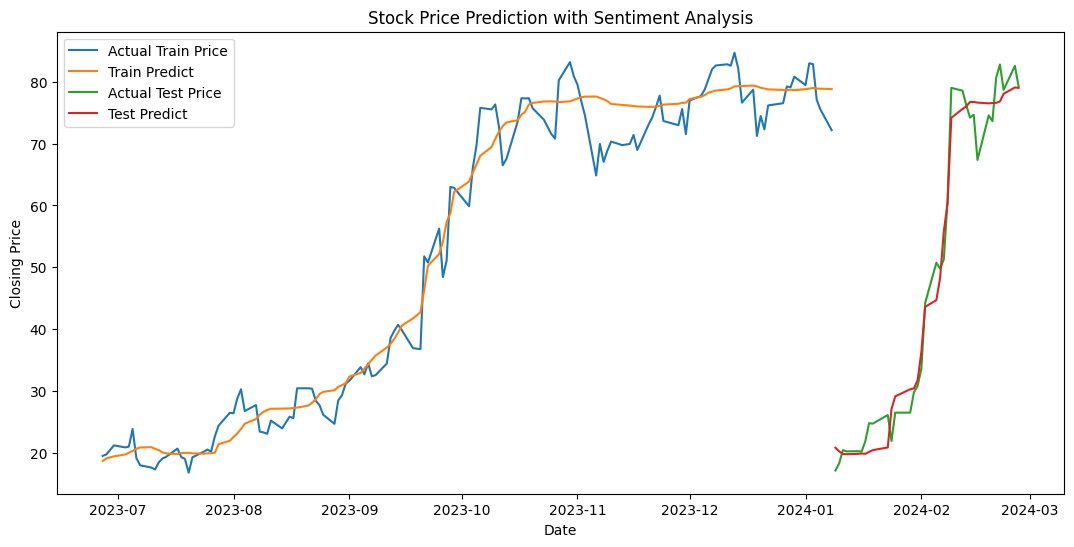

Train MAE: 3.045921822150996
Train MSE: 14.684601839350652
Train RMSE: 3.832049300224444
Train R2: 0.9755512254565372
Test MAE: 2.761413373791107
Test MSE: 12.142605064767407
Test RMSE: 3.484624092318626
Test R2: 0.9803420249829041


In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Make predictions on the training and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reshape the predictions to fit the scaler's expectations
train_predict = train_predict.reshape(-1, 1)
test_predict = test_predict.reshape(-1, 1)

# Invert scaling to get actual values
train_predict_inverse = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], X_train.shape[2]-1))), axis=1))[:, 0]
test_predict_inverse = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], X_test.shape[2]-1))), axis=1))[:, 0]

# Invert scaling for actual values as well
y_train_inverse = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X_train.shape[2]-1))), axis=1))[:, 0]
y_test_inverse = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2]-1))), axis=1))[:, 0]

# Plot the results
plt.figure(figsize=(13, 6))
plt.plot(combined_df.index[:len(y_train_inverse)], y_train_inverse, label='Actual Train Price')
plt.plot(combined_df.index[:len(train_predict_inverse)], train_predict_inverse, label='Train Predict')
plt.plot(combined_df.index[len(y_train_inverse):len(y_train_inverse) + len(y_test_inverse)], y_test_inverse, label='Actual Test Price')
plt.plot(combined_df.index[len(y_train_inverse):len(y_train_inverse) + len(test_predict_inverse)], test_predict_inverse, label='Test Predict')
plt.title('Stock Price Prediction with Sentiment Analysis')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train_inverse, train_predict_inverse)
train_mse = mean_squared_error(y_train_inverse, train_predict_inverse)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inverse, train_predict_inverse)

test_mae = mean_absolute_error(y_test_inverse, test_predict_inverse)
test_mse = mean_squared_error(y_test_inverse, test_predict_inverse)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_inverse, test_predict_inverse)

print(f'Train MAE: {train_mae}')
print(f'Train MSE: {train_mse}')
print(f'Train RMSE: {train_rmse}')
print(f'Train R2: {train_r2}')

print(f'Test MAE: {test_mae}')
print(f'Test MSE: {test_mse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R2: {test_r2}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Metrics:
MAE: 3.045921822150996
MSE: 14.684601839350652
RMSE: 3.832049300224444
R²: 0.9755512254565372

Testing Metrics:
MAE: 2.761413373791107
MSE: 12.142605064767407
RMSE: 3.484624092318626
R²: 0.9803420249829041


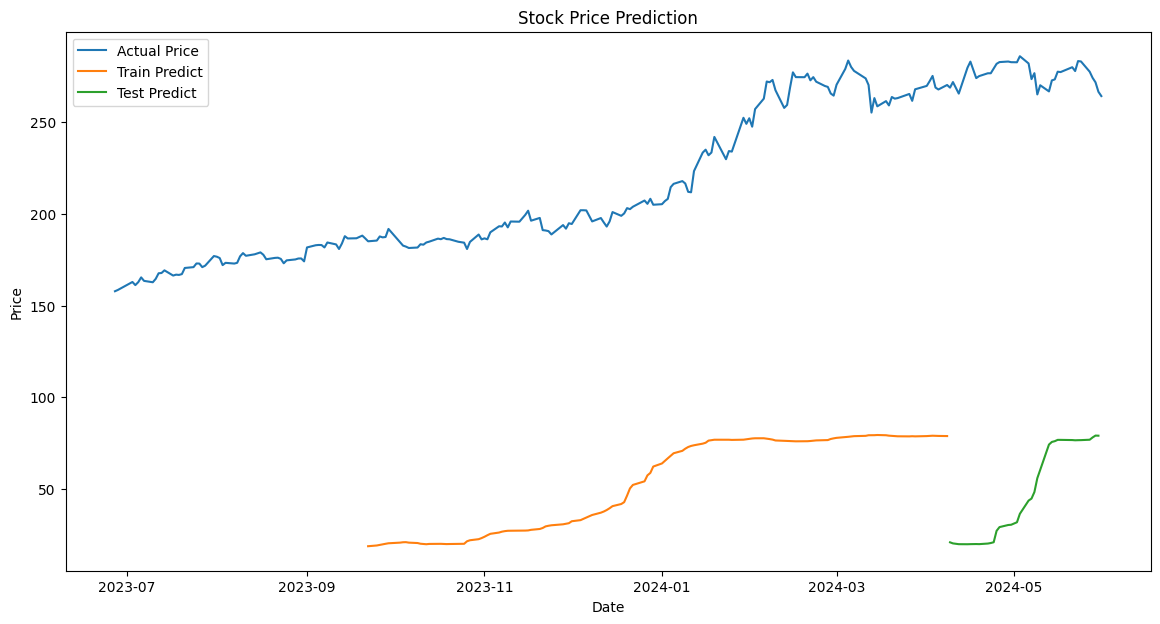

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming your data and model are already defined and trained

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

# Inverse transform the actual values
y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

# Calculate metrics for training set
train_mae = mean_absolute_error(y_train_actual, train_predict)
train_mse = mean_squared_error(y_train_actual, train_predict)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_actual, train_predict)

# Calculate metrics for testing set
if len(y_test_actual) > 1:
    test_mae = mean_absolute_error(y_test_actual, test_predict)
    test_mse = mean_squared_error(y_test_actual, test_predict)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test_actual, test_predict)
else:
    test_mae = test_mse = test_rmse = test_r2 = np.nan

print(f'Training Metrics:')
print(f'MAE: {train_mae}')
print(f'MSE: {train_mse}')
print(f'RMSE: {train_rmse}')
print(f'R²: {train_r2}')

print(f'\nTesting Metrics:')
print(f'MAE: {test_mae}')
print(f'MSE: {test_mse}')
print(f'RMSE: {test_rmse}')
print(f'R²: {test_r2}')

# Ensure the indices for plotting match the lengths of the predictions
train_plot_indices = combined_df.index[time_step:time_step + len(train_predict)]
test_plot_indices = combined_df.index[time_step + len(train_predict):time_step + len(train_predict) + len(test_predict)]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(combined_df.index, combined_df['Close'], label='Actual Price')
plt.plot(train_plot_indices, train_predict, label='Train Predict')
plt.plot(test_plot_indices, test_predict, label='Test Predict')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [38]:
# Predicting the next 30 days
last_days = scaled_features[-time_step:]

num_features = X.shape[2]
predictions = []

current_input = last_days.reshape(1, time_step, num_features)

for i in range(30):
    next_prediction = model.predict(current_input)
    predictions.append(next_prediction[0, 0])
    print(f"step {i+ 1}")

    next_prediction = next_prediction.reshape(1, 1, 1)
    next_prediction_tiled = np.tile(next_prediction, (1, 1, num_features))

    new_input = np.concatenate((current_input[:, 1:, :], next_prediction_tiled), axis=1)
    current_input = new_input

# Invert predictions to get actual values
predictions = np.array(predictions).reshape(-1, 1)
predictions_full = np.concatenate([predictions, np.zeros((predictions.shape[0], num_features - 1))], axis=1)
predictions = scaler.inverse_transform(predictions_full)[:, 0]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
step 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
step 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
step 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
step 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
step 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
step 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
step 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
step 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
step 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
step 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
step 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
step 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
step 13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
step 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
step 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
step 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
step 17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
step 18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
step 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
step 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
step 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
step

62.35495671068013


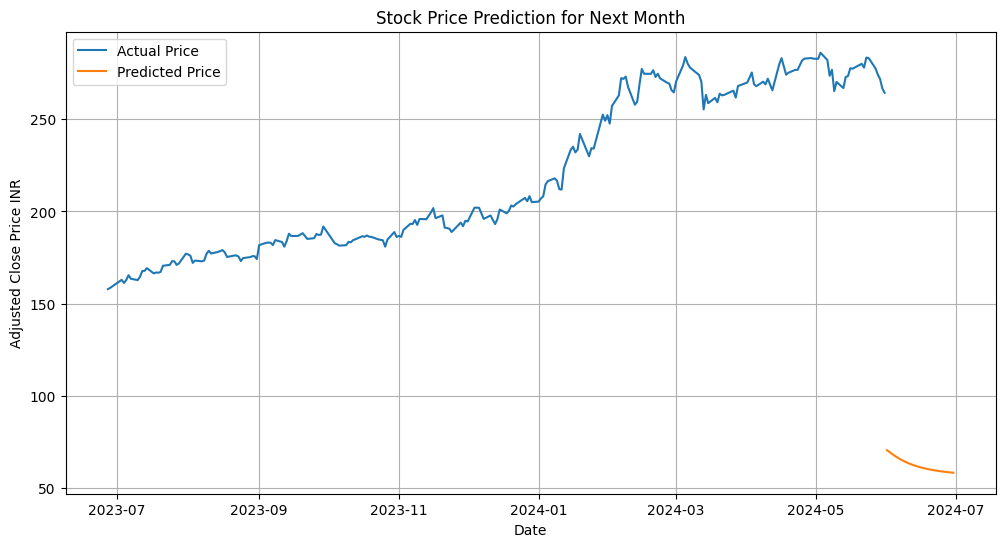

In [39]:
print(predictions.mean())

# Plot the predictions
future_dates = pd.date_range(start=combined_df.index[-1] + pd.Timedelta(days=1), periods=30)
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Close'], label='Actual Price')
plt.plot(future_dates, predictions, label='Predicted Price')
plt.title('Stock Price Prediction for Next Month')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price INR')
plt.legend()
plt.grid()
plt.show()

In [41]:
predictions
df_temp = pd.DataFrame(predictions, columns=['Close'])
df_temp

# average of predictions
print(df_temp['Close'].mean())
print(predictions.mean())

print(predictions)




62.35495671068013
62.35495671068013
[70.46895628 69.61554885 68.69004619 67.79288023 66.95287129 66.17588708
 65.45994374 64.80069847 64.19336927 63.63340114 63.11658949 62.63912449
 62.19761581 61.78893961 61.41033722 61.07248303 60.76062141 60.47148541
 60.20356    59.95519687 59.72487112 59.51114667 59.31277497 59.12856668
 58.95744598 58.79844561 58.6506526  58.51323293 58.38544143 58.26656744]


# **Tuning the model**

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


data = pd.read_csv('combined_data.csv')

# features and target

# Scaling of the features and target separately
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = feature_scaler.fit_transform(features)

target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Combine scaled features and target to create the dataset for LSTM
scaled_data = np.hstack((scaled_target, scaled_features[:, 1:]))

# Function to create dataset for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X.shape[2])))  # LSTM layer
    model.add(Dropout(0.3))  # Dropout layer
    model.add(GRU(100, return_sequences=False))  # GRU layer
    model.add(Dropout(0.3))  # Dropout layer
    model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))  # Dense layer with L2 regularization
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Define early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=5, batch_size=64, callbacks=[early_stop])
    # Evaluate the model
    predictions = model.predict(X_test)
    predictions = target_scaler.inverse_transform(predictions)

    # Inverse transform actual values
    y_test_scaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate performance metrics
    mae = mean_absolute_error(y_test_scaled, predictions)
    mse = mean_squared_error(y_test_scaled, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_scaled, predictions)

    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Print average performance metrics
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")


f:\Projects\Stock Preditction\src\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.9912 - val_loss: 0.7253
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - loss: 0.7339 - val_loss: 0.6419
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - loss: 0.6572 - val_loss: 0.6833
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - loss: 0.6744 - val_loss: 0.6158
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - loss: 0.6146 - val_loss: 0.5942
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


f:\Projects\Stock Preditction\src\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.0111 - val_loss: 0.6766
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step - loss: 0.7064 - val_loss: 0.6766
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - loss: 0.6746 - val_loss: 0.6268
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.6385 - val_loss: 0.6295
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - loss: 0.6252 - val_loss: 0.5831
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepWARNING:tensorflow:5 out of the last 44 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F45158A160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary ret

f:\Projects\Stock Preditction\src\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 750ms/step - loss: 1.0690 - val_loss: 0.7187
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 0.7162 - val_loss: 0.6541
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - loss: 0.6654 - val_loss: 0.6609
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.6668 - val_loss: 0.6322
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - loss: 0.6372 - val_loss: 0.6023
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  


f:\Projects\Stock Preditction\src\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 717ms/step - loss: 1.1282 - val_loss: 0.6705
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 0.6894 - val_loss: 0.6954
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.6937 - val_loss: 0.6443
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.6505 - val_loss: 0.6230
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.6293 - val_loss: 0.6052
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 766ms/step


f:\Projects\Stock Preditction\src\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 647ms/step - loss: 1.0360 - val_loss: 0.6611
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.6944 - val_loss: 0.6754
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.6882 - val_loss: 0.6307
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 0.6406 - val_loss: 0.6332
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.6315 - val_loss: 0.5913
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 726ms/step
Average MAE: 8.291697322961056
Average MSE: 103.30190256644353
Average RMSE: 10.020197465261369
Average R²: 0.9290714025185419
